## Predicting Store Sales using Machine Learning

In this notebook, I'll try to predict store sales independently.

## 1. Problem definition

> How well can we predict the future store sales given its past sales data?

## 2. Data

The data is downloaded from the Kaggle Store Sales - Time Series Forecasting competition: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

There are 6 main datasets.

## 3. Seasonality

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# define two functions: seasonal_plot and plot_periodogram
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    # fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    fs = 365
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [10]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv('store-sales-time-series-forecasting/train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

# store_sales['date'] = store_sales.date.dt.to_period('D')
# store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

<ipython-input-10-cd8a37cc3867>:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv('store-sales-time-series-forecasting/train.csv',


In [3]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000888 entries, ('1', 'AUTOMOTIVE', Period('2013-01-01', 'D')) to ('9', 'SEAFOOD', Period('2017-08-15', 'D'))
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   sales        float32
 2   onpromotion  uint64 
dtypes: float32(1), int64(1), uint64(1)
memory usage: 68.8 MB


In [11]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [12]:
average_sales = (
    store_sales.sales
    .groupby('date').mean()
    .squeeze()
)

average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

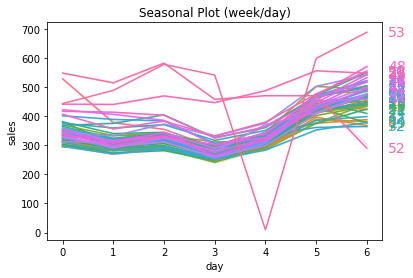

In [13]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

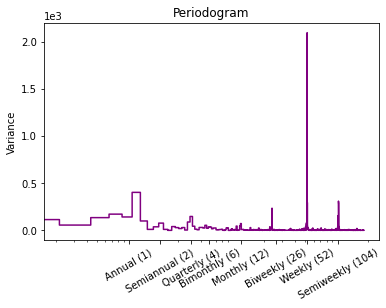

In [19]:
plot_periodogram(average_sales);

### (1) Determine seasonality

Both the seasonal plot and the periodogram suggest a **strong weekly seasonality**. 

From the periodogram, it appears there may be some **monthly** and **biweekly** components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

**Note**:

A periodogram is used to identify the dominant periods (or frequencies) of a time series. This can be a helpful tool for identifying the dominant cyclical behavior in a series, particularly when the cycles are not related to the commonly encountered monthly or quarterly seasonality.

### (2) Create seasonal features
Use **DeterministicProcess** and **CalendarFourier** to create:

* indicators for weekly seasons and
* Fourier features of order 4 for monthly seasons.

In [20]:
y = average_sales.copy()

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,         
    additional_terms=[fourier], 
    drop=True,
)
X = dp.in_sample() 

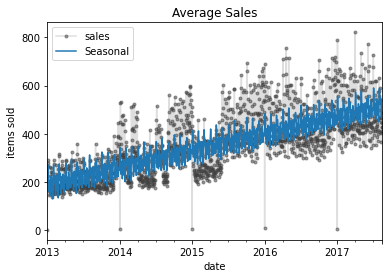

In [21]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.

Look at the periodogram of the deseasonalized series.

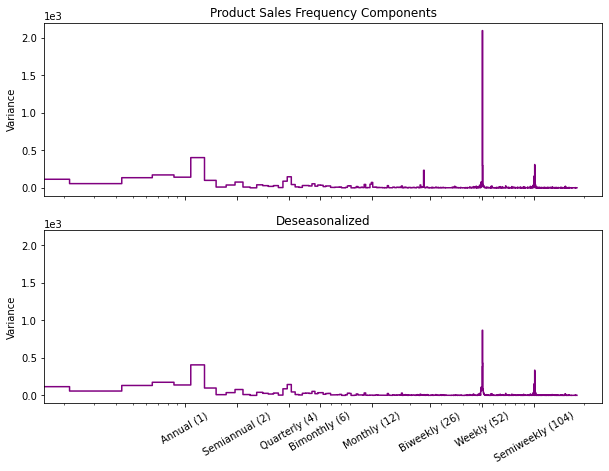

In [22]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

### (3) Check for remaining seasonality

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

### (4) Seasonality for holidays

The Store Sales dataset includes a table of Ecuadorian holidays.

In [23]:
holidays_events = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

<ipython-input-23-652bbb593c32>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv",


In [27]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2013':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2013-01-01,Primer dia del ano
2013-01-05,Recupero puente Navidad
2013-01-12,Recupero puente primer dia del ano
2013-02-11,Carnaval
2013-02-12,Carnaval
...,...
2017-05-24,Batalla de Pichincha
2017-05-26,Traslado Batalla de Pichincha
2017-06-25,Provincializacion de Imbabura


In [31]:
'2013-12-25' in holidays.index

True

From a plot of the deseasonalized Average Sales, it appears these holidays could have some predictive power.

The error message is "[Period('2013-12-25', 'D'), Period('2014-12-25', 'D'), Period('2015-12-25', 'D'), Period('2016-12-25', 'D')] not in index"


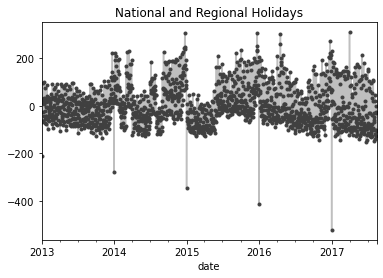

In [35]:
ax = y_deseason.plot(**plot_params)
try:
    plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
except Exception as e:
    print('The error message is {}'.format(e))
ax.set_title('National and Regional Holidays');

### (5) Create holiday features

In [36]:
# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

C:\Users\zxy23\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
# Pandas solution
X_holidays = pd.get_dummies(holidays)

In [38]:
# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

In [39]:
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Terremoto Manabi+5,description_Terremoto Manabi+6,description_Terremoto Manabi+7,description_Terremoto Manabi+8,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,False,False,False,False,False,False,False,False,False,False
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,False,False,False,False,False,False,False,False,False,False


In [43]:
y, X2 = y.align(X2, join='inner') # given that X2 misses some dates

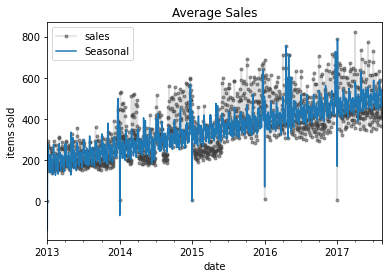

In [42]:
# Fit the seasonal model with holiday features added
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [54]:
X2.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)',
       'cos(4,freq=M)', 'description_Batalla de Pichincha',
       'description_Black Friday', 'description_Carnaval',
       'description_Cyber Monday', 'description_Dia de Difuntos',
       'description_Dia de la Madre', 'description_Dia de la Madre-1',
       'description_Dia del Trabajo',
       'description_Inauguracion Mundial de futbol Brasil',
       'description_Independencia de Cuenca',
       'description_Independencia de Guayaquil',
       'description_Mundial de futbol Brasil: Cuartos de Final',
       'description_Mundial de futbol Brasil: Ecuador-Francia',
       'description_Mundial de futbol Brasil: Ecuador-Honduras',
       'description_Mundial de futbol Brasil: Ecuador-Suiza',
       'description_Mundial de futbol Brasil: Final',
       'description_Mun

In [60]:
y.columns

MultiIndex([(         'id', '1',                 'AUTOMOTIVE'),
            (         'id', '1',                  'BABY CARE'),
            (         'id', '1',                     'BEAUTY'),
            (         'id', '1',                  'BEVERAGES'),
            (         'id', '1',                      'BOOKS'),
            (         'id', '1',               'BREAD/BAKERY'),
            (         'id', '1',                'CELEBRATION'),
            (         'id', '1',                   'CLEANING'),
            (         'id', '1',                      'DAIRY'),
            (         'id', '1',                       'DELI'),
            ...
            ('onpromotion', '9',                  'MAGAZINES'),
            ('onpromotion', '9',                      'MEATS'),
            ('onpromotion', '9',              'PERSONAL CARE'),
            ('onpromotion', '9',               'PET SUPPLIES'),
            ('onpromotion', '9',    'PLAYERS AND ELECTRONICS'),
            ('onpromotio

In [61]:
y_pred

date
2013-01-01   -139.417425
2013-01-02    259.187490
2013-01-03    275.024591
2013-01-04    265.565957
2013-01-05    267.873260
                 ...    
2017-08-11    467.887069
2017-08-12    474.539097
2017-08-13    504.181786
2017-08-14    524.540688
2017-08-15    532.618381
Freq: D, Length: 1689, dtype: float64

### (6). New seasonal model for the competition

creates a seasonal model of the kind for the full Store Sales dataset with all 1800 time series

In [144]:
y = store_sales.unstack(['store_nbr', 'family']) # .loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

# Join to training data
X2_train = X.join(X_holidays, on='date').fillna(0.0)

y, X2_train = y.align(X2_train, join='inner', axis = 0)

model = LinearRegression(fit_intercept=False)
model.fit(X2_train, y)
y_pred = pd.DataFrame(model.predict(X2_train), index=X2_train.index, columns=y.columns)

In [79]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False


In [212]:
y = store_sales.unstack(['store_nbr', 'family'])

y.head()

sales                                                 
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000  \
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ... onpromotion         
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0  \
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   

                                                                        
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0  \
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  

[5 rows x 3564 columns]

### (7) Make predictions

Now load the test data, create a feature set for the forecast period, and then create the submission file `submission.csv`.

In [145]:
df_test = pd.read_csv('store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# df_test = df_test.set_index('date').to_period('D')
# df_test = df_test.set_index(['store_nbr', 'family'], append=True)

<ipython-input-145-e225cca6ff29>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_test = pd.read_csv('store-sales-time-series-forecasting/test.csv',


In [146]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

In [199]:
X_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958,False
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958,False
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,False
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394,False
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139,False


In [147]:
# Join to testing data
X2_test = X_test.join(X_holidays, on='date').fillna(0.0)

In [148]:
y_submit = pd.DataFrame(model.predict(X2_test), index=X_test.index, columns=y.columns)

In [149]:
y_submit.head()

id                                               
store_nbr           1                                               
family     AUTOMOTIVE  BABY CARE     BEAUTY  BEVERAGES      BOOKS   
date                                                                
2017-08-16  3000888.0  3000889.0  3000890.0  3000891.0  3000892.0  \
2017-08-17  3002670.0  3002671.0  3002672.0  3002673.0  3002674.0   
2017-08-18  3004452.0  3004453.0  3004454.0  3004455.0  3004456.0   
2017-08-19  3006234.0  3006235.0  3006236.0  3006237.0  3006238.0   
2017-08-20  3008016.0  3008017.0  3008018.0  3008019.0  3008020.0   

                                                                      ...   
store_nbr                                                             ...   
family     BREAD/BAKERY CELEBRATION   CLEANING      DAIRY       DELI  ...   
date                                                                  ...   
2017-08-16    3000893.0   3000894.0  3000895.0  3000896.0  3000897.0  ...  \
2017-08-17    3002675.0   3002676.0  3002677.0  3002678.0  3002679.0  ...   
2017-08-18    3004457.0   3004458.0  3004459.0  3004460.0  3004461.0  ...   
2017-08-19    3006239.0   3006240.0  3006241.0  3006242.0  3006243.0  ...   
2017-08-20    3008021.0   3008022.0  3008023.0  3008024.0  3008025.0  ...   

           onpromotion                                        
store_nbr            9                                        
family       MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date                                                          
2017-08-16    0.003804  2.140527     11.913248     0.090158  \
2017-08-17    0.001898  5.005857     11.912153     0.097702   
2017-08-18    0.002577  6.559677     11.791694     0.094590   
2017-08-19    0.009186  6.527904     11.563018     0.129425   
2017-08-20    0.020914  5.153571     11.639372     0.125218   

                                                                         
store_nbr                                                                
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS    PRODUCE   
date                                                                     
2017-08-16                0.040983  1.995875       2.572573  49.201787  \
2017-08-17                0.038210  2.189782       4.034502  36.034118   
2017-08-18                0.055680  5.016975       3.062688  27.516135   
2017-08-19                0.088919  7.538227       1.789058  16.015295   
2017-08-20                0.123253  7.239064       1.695822  16.215722   

                                                 
store_nbr                                        
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-08-16                   0.641053  0.539090  
2017-08-17                   0.622471  0.544082  
2017-08-18                   0.609036  0.583866  
2017-08-19                   0.600001  1.277436  
2017-08-20                   0.754612  1.665951  

[5 rows x 5346 columns]

In [150]:
y_submit = y_submit.stack(['store_nbr', 'family'])

In [97]:
y_submit.head()

id  onpromotion        sales
date       store_nbr family                                         
2017-08-16 1         AUTOMOTIVE  3000888.0     0.000000     4.274030
                     BABY CARE   3000889.0     0.000000     0.000000
                     BEAUTY      3000890.0     0.471277     3.495530
                     BEVERAGES   3000891.0    28.190901  2414.541711
                     BOOKS       3000892.0     0.000000     0.438314

In [99]:
df_test.head()

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [151]:
y_submit_final = y_submit.join(df_test.id, lsuffix='id')

In [152]:
y_submit_final.head()

idid  onpromotion        sales       id
date       store_nbr family                                                  
2017-08-16 1         AUTOMOTIVE  3000888.0     0.028952     4.286732  3000888
                     BABY CARE   3000889.0     0.000000     0.000000  3000889
                     BEAUTY      3000890.0     0.396692     3.306981  3000890
                     BEVERAGES   3000891.0    27.182288  2387.574119  3000891
                     BOOKS       3000892.0     0.000000     0.481048  3000892

In [153]:
y_submit_final = y_submit_final.reset_index(drop=True)

In [154]:
y_submit_final = y_submit_final[['id', 'sales']]
y_submit_final

,id,sales
0,3000888,4.286732
1,3000889,0.000000
2,3000890,3.306981
3,3000891,2387.574119
4,3000892,0.481048
...,...,...
28507,3029395,507.492954
28508,3029396,126.624514
28509,3029397,2026.567367
28510,3029398,12.853579


In [120]:
y_submit_final = y_submit_final.reindex(columns=['id', 'sales'])
y_submit_final

,id,sales
0,3000888,4.274030
1,3000889,0.000000
2,3000890,3.495530
3,3000891,2414.541711
4,3000892,0.438314
...,...,...
28507,3029395,372.417153
28508,3029396,107.843530
28509,3029397,1273.316507
28510,3029398,44.945937


In [156]:
# y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
# y_submit_final = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])

In [155]:
y_submit.to_csv('submission_test4.csv', index=False)

## 4. Hybrid Models

In [157]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

In [173]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

In [174]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False


In the next two questions, you'll create a **boosted hybrid** for the Store Sales dataset by implementing a new Python class. Run the next cell to create the initial class definition. You'll add `fit` and `predict` methods to give it a scikit-learn like interface.

In [161]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

### (1) Define fit method for boosted hybrid
Complete the `fit` definition for the BoostedHybrid class. 

In [224]:
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    # y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

### (2) Define predict method for boosted hybrid
Now define the `predict` method for the BoostedHybrid class. 

In [241]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    # y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred #.unstack()


# Add method to class
BoostedHybrid.predict = predict

Now you're ready to use your new `BoostedHybrid` class to create a model for the Store Sales data.

In [178]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [179]:
family_sales.head()

sales                                               
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000  \
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                            
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167  \
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                        
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519  \
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                          
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630  \
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [214]:
# Target series
y.head()

sales                                                 
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000  \
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ... onpromotion         
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0  \
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   

                                                                        
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0  \
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  

[5 rows x 3564 columns]

In [187]:
len(y)

1684

In [189]:
len(X_1), len(X_2)

(1684, 7491)

In [198]:
X_2.head()

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1


In [ ]:
y, X2_train = y.align(X2_train, join='inner', axis = 0)

In [177]:
# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = X

In [180]:
# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

In [181]:
# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [190]:
X_2.head()

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1


In [194]:
X_3 = (
    store_sales.onpromotion
    .groupby('date').mean()
    .squeeze()
)

X_3.head()

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
Freq: D, Name: onpromotion, dtype: float64

In [195]:
len(X_3)

1684

In [202]:
df_test.head()

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [ ]:
X4 = df_test.aggregate({"id":['sum', 'min'],
              "Age":['max', 'min'],
              "Weight":['min', 'sum'], 
              "Salary":['sum']})

In [208]:
X_3_test = (
    df_test.onpromotion
    .groupby('date').mean()
    .squeeze()
)

X_3_test.head()

date
2017-08-16    17.137486
2017-08-17     4.211560
2017-08-18     7.731201
2017-08-19     4.833895
2017-08-20     5.338384
Freq: D, Name: onpromotion, dtype: float64

### (3) Train boosted hybrid
Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `XGBRegressor()` instances.

In [226]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_3, y)

# y_pred = model.predict(X_1, X_3)
# y_pred = y_pred.clip(0.0)

In [222]:
X_1.shape, X_3.shape, y.shape

((1684, 17), (1684,), (1684, 3564))

In [220]:
X_test.shape, X_3_test.shape

((16, 17), (16,))

In [242]:
y_pred = model.predict(X_test, X_3_test)

In [243]:
y_pred.head()

sales                                                  
store_nbr           1                                                  
family     AUTOMOTIVE     BABY CARE    BEAUTY    BEVERAGES     BOOKS   
date                                                                   
2017-08-16   1.213026  1.658892e-16  4.079438  3225.355209  0.251629  \
2017-08-17   3.316129  1.658892e-16  5.066726  2803.803921  0.208475   
2017-08-18   4.331481  1.658892e-16  2.575997  2646.897549  4.100391   
2017-08-19   7.507626  1.658892e-16  4.428639  2751.329653  0.235852   
2017-08-20   4.200576  1.658892e-16  1.956448  2544.799975  0.174874   

                                                                         ...   
store_nbr                                                                ...   
family     BREAD/BAKERY CELEBRATION    CLEANING       DAIRY        DELI  ...   
date                                                                     ...   
2017-08-16   536.304726   19.295573  910.699481  974.721543  200.242148  ...  \
2017-08-17   468.075471   42.985936  676.198491  970.127449  162.342335  ...   
2017-08-18   457.647032   19.850538  886.282555  876.513467  175.305234  ...   
2017-08-19   455.324412   20.276618  754.598128  897.692099  148.292902  ...   
2017-08-20   445.219767   16.561973  745.853674  818.628259  160.035630  ...   

           onpromotion                                        
store_nbr            9                                        
family       MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date                                                          
2017-08-16   -0.003649 -1.304277     17.508714     0.021764  \
2017-08-17   -0.010369  3.876195     10.914747     0.022659   
2017-08-18   -0.004812  4.915463     12.313161     0.020224   
2017-08-19    0.006341  3.832015      9.887738     0.139941   
2017-08-20    0.015199  4.180327     12.951058     0.046482   

                                                                         
store_nbr                                                                
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS    PRODUCE   
date                                                                     
2017-08-16               -0.003302  1.607571       8.941910  22.006001  \
2017-08-17               -0.014278  8.688476       3.702702  29.528174   
2017-08-18                0.014025  4.599090       3.025098  16.342518   
2017-08-19                0.069651  4.636723       7.954946  12.486061   
2017-08-20                0.079438  7.659454       1.596864   3.129741   

                                                 
store_nbr                                        
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-08-16                   0.010777  1.046870  
2017-08-17                   0.265393 -0.321680  
2017-08-18                   0.350233  0.168000  
2017-08-19                   0.829816  0.766490  
2017-08-20                   0.362665  1.235119  

[5 rows x 3564 columns]

In [ ]:
.stack(['store_nbr', 'family'])

In [244]:
y_pred = y_pred.stack(['store_nbr', 'family'])
y_pred.head()

onpromotion         sales
date       store_nbr family                                
2017-08-16 1         AUTOMOTIVE  3.217984e-03  1.213026e+00
                     BABY CARE   1.658892e-16  1.658892e-16
                     BEAUTY      1.022991e+00  4.079438e+00
                     BEVERAGES   8.807730e+01  3.225355e+03
                     BOOKS       1.658892e-16  2.516288e-01

In [248]:
y_pred_final = y_pred.join(df_test.id, lsuffix='id')

In [249]:
y_pred_final

onpromotion         sales   
date       store_nbr family                                                   
2017-08-16 1         AUTOMOTIVE                  3.217984e-03  1.213026e+00  \
                     BABY CARE                   1.658892e-16  1.658892e-16   
                     BEAUTY                      1.022991e+00  4.079438e+00   
                     BEVERAGES                   8.807730e+01  3.225355e+03   
                     BOOKS                       1.658892e-16  2.516288e-01   
...                                                       ...           ...   
2017-08-31 9         POULTRY                    -8.404194e-01  6.026962e+02   
                     PREPARED FOODS              4.468662e+00  1.691386e+02   
                     PRODUCE                     2.551381e+01  2.333077e+03   
                     SCHOOL AND OFFICE SUPPLIES  2.041617e-01 -1.668846e-01   
                     SEAFOOD                    -1.982666e-01  1.580232e+01   

                                                      id  
date       store_nbr family                               
2017-08-16 1         AUTOMOTIVE                  3000888  
                     BABY CARE                   3000889  
                     BEAUTY                      3000890  
                     BEVERAGES                   3000891  
                     BOOKS                       3000892  
...                                                  ...  
2017-08-31 9         POULTRY                     3029395  
                     PREPARED FOODS              3029396  
                     PRODUCE                     3029397  
                     SCHOOL AND OFFICE SUPPLIES  3029398  
                     SEAFOOD                     3029399  

[28512 rows x 3 columns]

In [252]:
y_pred_final = y_pred_final.reset_index(drop=True)
y_pred_final = y_pred_final[['id', 'sales']]
y_pred_final

,id,sales
0,3000888,1.213026e+00
1,3000889,1.658892e-16
2,3000890,4.079438e+00
3,3000891,3.225355e+03
4,3000892,2.516288e-01
...,...,...
28507,3029395,6.026962e+02
28508,3029396,1.691386e+02
28509,3029397,2.333077e+03
28510,3029398,-1.668846e-01


In [253]:
y_pred_final.to_csv('submission_test5.csv', index=False)

In [254]:
y_submit = pd.DataFrame(model.predict(X_test, X_3_test), index=X_test.index, columns=y.columns)

In [255]:
y_submit.head()

sales                                                  
store_nbr           1                                                  
family     AUTOMOTIVE     BABY CARE    BEAUTY    BEVERAGES     BOOKS   
date                                                                   
2017-08-16   1.213026  1.658892e-16  4.079438  3225.355209  0.251629  \
2017-08-17   3.316129  1.658892e-16  5.066726  2803.803921  0.208475   
2017-08-18   4.331481  1.658892e-16  2.575997  2646.897549  4.100391   
2017-08-19   7.507626  1.658892e-16  4.428639  2751.329653  0.235852   
2017-08-20   4.200576  1.658892e-16  1.956448  2544.799975  0.174874   

                                                                         ...   
store_nbr                                                                ...   
family     BREAD/BAKERY CELEBRATION    CLEANING       DAIRY        DELI  ...   
date                                                                     ...   
2017-08-16   536.304726   19.295573  910.699481  974.721543  200.242148  ...  \
2017-08-17   468.075471   42.985936  676.198491  970.127449  162.342335  ...   
2017-08-18   457.647032   19.850538  886.282555  876.513467  175.305234  ...   
2017-08-19   455.324412   20.276618  754.598128  897.692099  148.292902  ...   
2017-08-20   445.219767   16.561973  745.853674  818.628259  160.035630  ...   

           onpromotion                                        
store_nbr            9                                        
family       MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date                                                          
2017-08-16   -0.003649 -1.304277     17.508714     0.021764  \
2017-08-17   -0.010369  3.876195     10.914747     0.022659   
2017-08-18   -0.004812  4.915463     12.313161     0.020224   
2017-08-19    0.006341  3.832015      9.887738     0.139941   
2017-08-20    0.015199  4.180327     12.951058     0.046482   

                                                                         
store_nbr                                                                
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS    PRODUCE   
date                                                                     
2017-08-16               -0.003302  1.607571       8.941910  22.006001  \
2017-08-17               -0.014278  8.688476       3.702702  29.528174   
2017-08-18                0.014025  4.599090       3.025098  16.342518   
2017-08-19                0.069651  4.636723       7.954946  12.486061   
2017-08-20                0.079438  7.659454       1.596864   3.129741   

                                                 
store_nbr                                        
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-08-16                   0.010777  1.046870  
2017-08-17                   0.265393 -0.321680  
2017-08-18                   0.350233  0.168000  
2017-08-19                   0.829816  0.766490  
2017-08-20                   0.362665  1.235119  

[5 rows x 3564 columns]

In [ ]:
y_submit = y_submit.stack(['store_nbr', 'family'])

In [200]:
X2_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Terremoto Manabi+5,description_Terremoto Manabi+6,description_Terremoto Manabi+7,description_Terremoto Manabi+8,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.299363,-0.954139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.485302,-0.874347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
y_pred.head()

,sales
date,
2013-01-01,0.000000
2013-01-02,263.510808
2013-01-03,274.867870
2013-01-04,260.782406
2013-01-05,236.748320


Depending on your problem, you might want to use other hybrid combinations than the linear regression + XGBoost hybrid you've created in the previous cell.

In [167]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

These are just some suggestions. You might discover other algorithms you like in the scikit-learn User Guide (https://scikit-learn.org/stable/supervised_learning.html).

Use the code in the next cell to see the predictions that hybrid makes.

In [168]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

In [169]:
y_pred.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-07-02,7.874687,0.202835,7.770656,4297.568657,0.000000,1316.177964,12.767738,2282.842270,1070.677326,341.418630,...,6.062945,415.466485,407.435700,9.695107,14.644399,422.083815,99.072053,2797.912236,4.732669,22.544516
2017-07-03,8.219132,0.125057,5.711662,3946.922692,0.024070,552.522725,15.045515,1788.266492,932.985643,316.977177,...,4.894556,379.713220,381.968106,9.995107,12.062684,395.229517,87.688533,2899.989445,4.736373,20.620768
2017-07-04,9.867280,0.210242,8.637503,3581.888411,0.023597,539.697313,16.486256,1680.838686,908.620043,320.448310,...,5.842704,386.971915,467.899078,11.946959,14.381202,429.218310,99.811112,2602.787722,4.880064,21.643495
2017-07-05,8.593206,0.216160,6.107958,4387.098546,0.042589,717.004412,12.997367,1593.473602,1011.573285,434.589383,...,5.683445,380.021311,416.287964,10.482390,13.374473,422.572189,91.943552,3146.061489,4.674776,22.239393
2017-07-06,7.485799,0.125046,4.904180,4464.672136,0.000000,560.896181,15.210233,1510.806108,1029.979592,261.738898,...,5.573284,350.252967,336.274841,8.200373,9.937663,341.872644,88.589773,2464.892710,3.584994,18.623035
